# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data?resource=download . Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

#### Libraries

In [55]:
# Your code here
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

#### Data

In [2]:
data = pd.read_csv('finance.csv')
print(data.shape)
data.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Sample the data

In [6]:
sampled_data = data.sample(n=100000, random_state=42)

print(sampled_data.shape)

(100000, 11)


In [8]:
sampled_data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0
3494160,259,PAYMENT,915.13,C2002954533,0.00,0.00,M290849763,0.00,0.00,0,0
2331654,188,CASH_OUT,20603.87,C813757373,0.00,0.00,C823291717,558068.66,578672.53,0,0
1414955,139,CASH_OUT,58605.72,C1850864812,0.00,0.00,C618657299,585494.94,644100.66,0,0
2938135,230,PAYMENT,4865.11,C886849972,0.00,0.00,M623175144,0.00,0.00,0,0
6133806,544,CASH_OUT,118131.63,C390714641,0.00,0.00,C366360355,8131691.35,8476246.86,0,0


In [9]:
sampled_data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

#### Check dtypes and null values

In [10]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 3737323 to 6142173
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.2+ MB


#### Target is 'isFraud' and the column 'isFlaggedFraud' is their own predictor

In [11]:
display(sampled_data[['isFraud', 'isFlaggedFraud']].sample(5))

display(sampled_data[['isFraud', 'isFlaggedFraud']].dtypes)

display(sampled_data['isFraud'].value_counts())
display(sampled_data['isFlaggedFraud'].value_counts())

,isFraud,isFlaggedFraud
3032562,0,0
4732042,0,0
4238142,0,0
3625745,0,0
2011344,0,0


isFraud           int64
isFlaggedFraud    int64
dtype: object

isFraud
0    99859
1      141
Name: count, dtype: int64

isFlaggedFraud
0    99999
1        1
Name: count, dtype: int64

In [12]:
sampled_data[sampled_data['isFlaggedFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1


In [ ]:
"""
The flagged fraud was correct in one true positive yet it has 140 false negatives.

"""

#### Check the stats

In [13]:
sampled_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.000000
mean,243.709070,1.805811e+05,8.366804e+05,8.582234e+05,1.104193e+06,1.230055e+06,0.001410,0.000010
std,142.518613,5.586699e+05,2.901104e+06,2.936799e+06,3.223011e+06,3.475326e+06,0.037524,0.003162
min,1.000000,9.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,156.000000,1.350821e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,240.000000,7.603086e+04,1.393850e+04,0.000000e+00,1.387482e+05,2.185786e+05,0.000000,0.000000
75%,335.000000,2.091130e+05,1.070771e+05,1.464169e+05,9.605963e+05,1.126011e+06,0.000000,0.000000
max,736.000000,3.697390e+07,3.359321e+07,3.388709e+07,2.362896e+08,2.724047e+08,1.000000,1.000000


#### Min and Max amounts

In [14]:
max_amount = sampled_data[sampled_data['amount'] == sampled_data['amount'].max()]
min_amount = sampled_data[sampled_data['amount'] == sampled_data['amount'].min()]

display(min_amount)
display(max_amount)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3315295,252,PAYMENT,0.92,C66974126,0.0,0.0,M1698108356,0.0,0.0,0,0


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3867478,283,TRANSFER,36973901.85,C1041279319,0.0,0.0,C1512993148,56605084.67,93578986.52,0,0


In [15]:
sampled_data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

<Axes: >

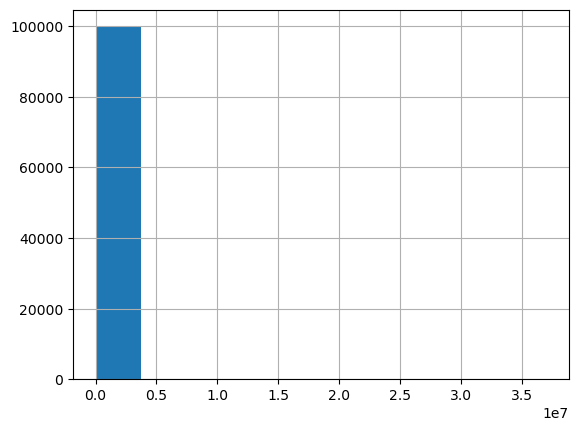

In [22]:
sampled_data['amount'].hist()

#### Adjust the distribution

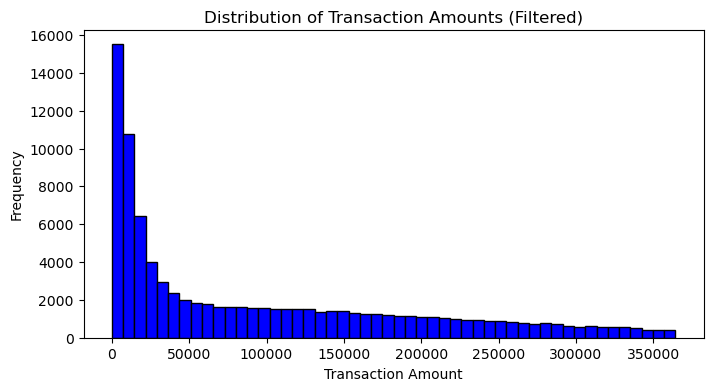

In [34]:
threshold = sampled_data['amount'].quantile(0.90)

# Filter the data to exclude amounts greater than the threshold
filtered_data = sampled_data[sampled_data['amount'] <= threshold]

plt.figure(figsize=(8, 4))
plt.hist(filtered_data['amount'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Transaction Amounts (Filtered)')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

#### Check with Log transform

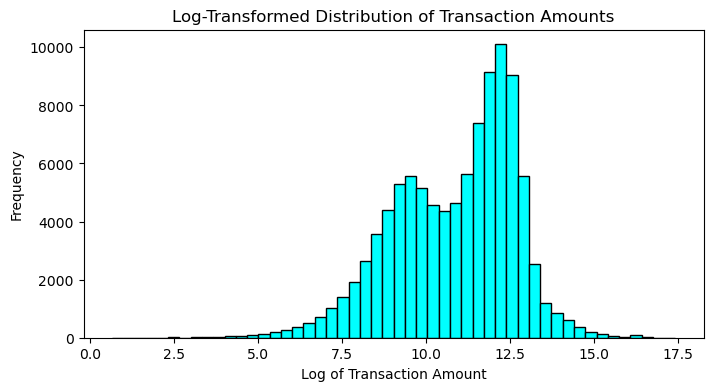

In [33]:
log_transformed_data = np.log1p(sampled_data['amount'])

# Plot the histogram of the log-transformed data
plt.figure(figsize=(8, 4))
plt.hist(log_transformed_data, bins=50, color='cyan', edgecolor='black')

plt.title('Log-Transformed Distribution of Transaction Amounts')
plt.xlabel('Log of Transaction Amount')
plt.ylabel('Frequency')
plt.show()

#### Check the users and type

In [36]:
sampled_data['nameOrig'].nunique()

99999

In [37]:
sampled_data['nameDest'].nunique()

92914

In [38]:
sampled_data['type'].nunique()

5

In [39]:
sampled_data['type'].value_counts()

type
CASH_OUT    35334
PAYMENT     33564
CASH_IN     22141
TRANSFER     8349
DEBIT         612
Name: count, dtype: int64

#### Fraudulent transactions and their types

In [40]:
sampled_data.groupby('type')['isFraud'].sum()

type
CASH_IN      0
CASH_OUT    62
DEBIT        0
PAYMENT      0
TRANSFER    79
Name: isFraud, dtype: int64

In [ ]:
"""
Cash out and Transfer is the only fraudulent

"""

#### How many transactions per user

In [43]:
nameDest_counts = sampled_data['nameDest'].value_counts()

nameDest_counts_above_1 = nameDest_counts[nameDest_counts > 1]
nameDest_counts_above_1

nameDest
C1085553281    6
C1040847151    5
C1009406898    5
C1495761010    5
C709091500     5
              ..
C1198398849    2
C1663021728    2
C1529167375    2
C1864534943    2
C425231479     2
Name: count, Length: 6289, dtype: int64

In [44]:
sampled_data[sampled_data['nameDest'] == 'C1085553281']

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3993414,298,CASH_OUT,236222.49,C1246882324,32331.00,0.00,C1085553281,625865.58,862088.06,0,0
699642,36,CASH_IN,80717.67,C1782188042,5268034.81,5348752.48,C1085553281,137112.13,56394.46,0,0
4661055,330,TRANSFER,309002.85,C1172194822,130691.00,0.00,C1085553281,1074980.25,1383983.10,0,0
4232718,306,CASH_OUT,212892.19,C576904087,21101.00,0.00,C1085553281,862088.06,1074980.25,0,0
2793501,215,CASH_OUT,333608.14,C1920122155,0.00,0.00,C1085553281,350985.63,684593.77,0,0
159015,12,CASH_OUT,207861.13,C720426124,252495.00,44633.87,C1085553281,39010.00,273204.04,0,0


#### Check the amount distribution in fraudulent transactions

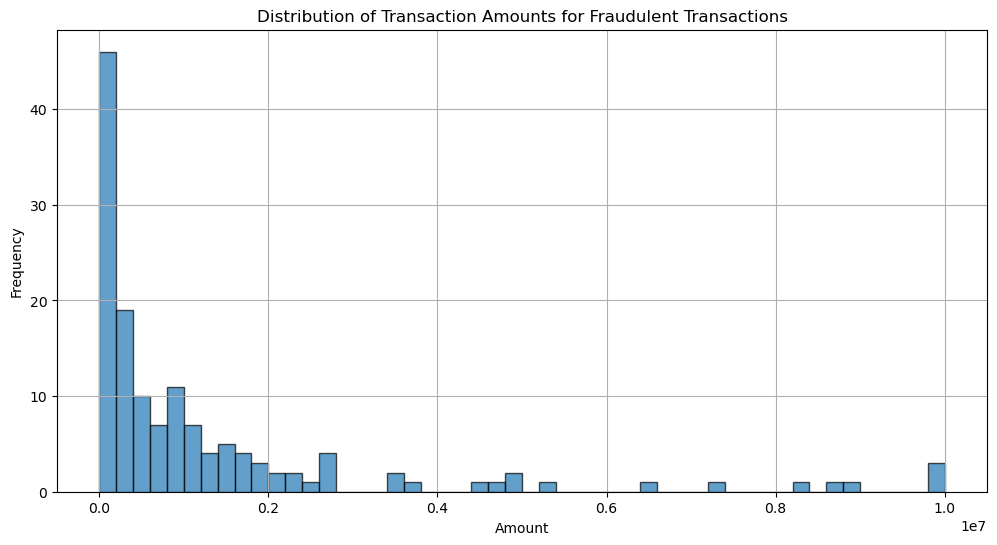

In [64]:
fraudulent_transactions = sampled_data[sampled_data['isFraud'] == 1]

# Plot the histogram of 'amount' for fraudulent transactions
plt.figure(figsize=(12, 6))
plt.hist(fraudulent_transactions['amount'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Transaction Amounts for Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

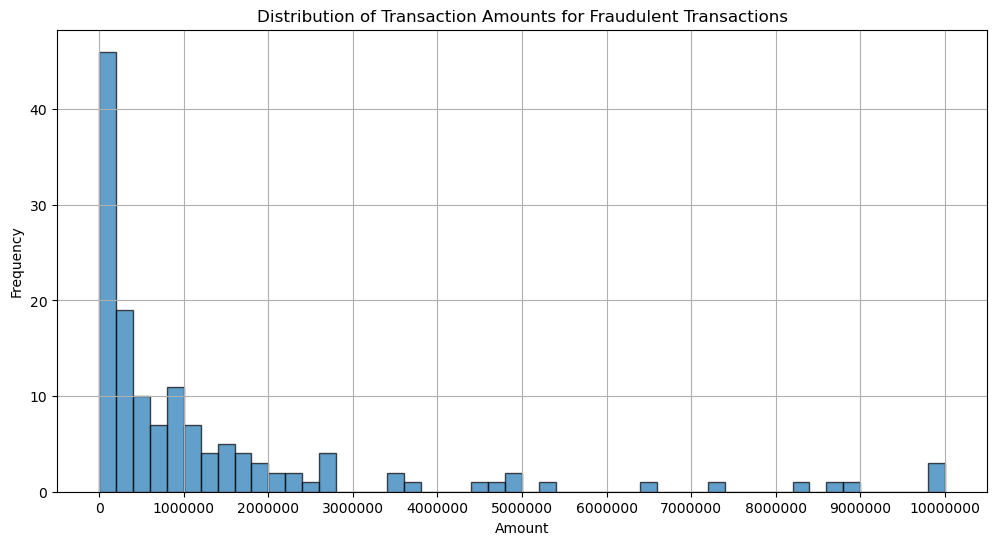

In [63]:
fraudulent_transactions = sampled_data[sampled_data['isFraud'] == 1]

# Plot the histogram of 'amount' for fraudulent transactions
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(fraudulent_transactions['amount'], bins=50, edgecolor='k', alpha=0.7)

# Customize x-axis labels
# Create a list of labels for the x-axis ticks
tick_labels = [f'{x:.0f}' for x in range(0, int(fraudulent_transactions['amount'].max()) + 1, int(fraudulent_transactions['amount'].max() // 10))]

# Set x-axis ticks and labels
plt.xticks(ticks=list(range(0, int(fraudulent_transactions['amount'].max()) + 1, int(fraudulent_transactions['amount'].max() // 10))), labels=tick_labels)

plt.title('Distribution of Transaction Amounts for Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Basic "stupid" model - going straight for the heaviest model

In [47]:
X = sampled_data.drop(columns=['type','nameOrig','nameDest', 'isFraud'])
y = sampled_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy Score: 0.9995
Confusion Matrix:
[[19970     2]
 [    8    20]]


In [ ]:
"""
The model has high accuracy, there are very few false positives (2) and false negatives (8)

For fraud detection we want to minimize false negatives, false positives are okay to have

We can improve

"""

### Check Feature Importance

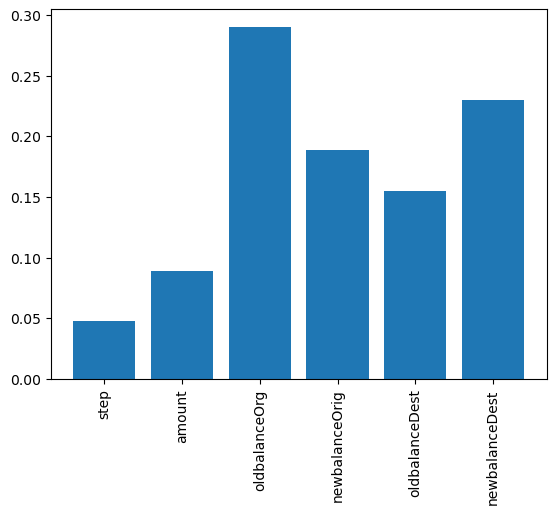

In [109]:
fig, ax = plt.subplots()
ax.bar(range(len(xgb_reg.feature_importances_)), xgb_reg.feature_importances_)
plt.xticks(range(6),X.columns,rotation=90)
plt.show()

### What is the distribution of the outcome? 

In [110]:
sampled_data['isFraud'].value_counts()

isFraud
0    99859
1      141
Name: count, dtype: int64

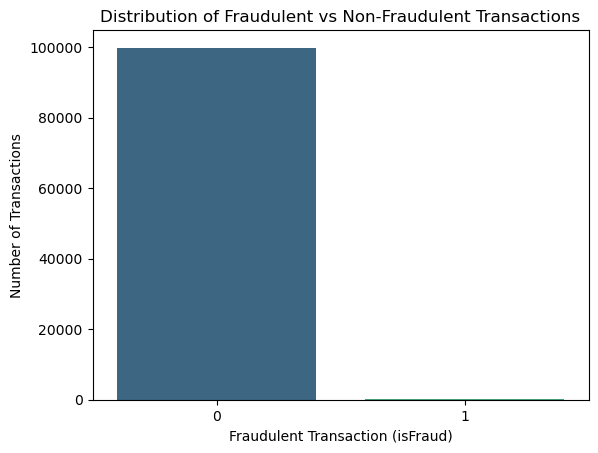

In [111]:
# Your response here
fraud_counts = sampled_data['isFraud'].value_counts()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')
plt.xlabel('Fraudulent Transaction (isFraud)')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')

plt.show()

### Clean the dataset. Pre-process it to make it suitable for ML training. Feel free to explore, drop, encode, transform, etc. Whatever you feel will improve the model score.

In [51]:
# Your code here
sampled_data = pd.get_dummies(sampled_data, columns=['type'], dtype=int)
sampled_data

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
3737323,278,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0,1,0,0,0,0
264914,15,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0,0,0,0,1,0
85647,10,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0,1,0,0,0,0
5899326,403,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0,0,0,0,0,1
2544263,206,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113342,235,371042.71,C1973614102,1699365.85,2070408.56,C1358214518,4301572.86,3930530.15,0,0,1,0,0,0,0
5156943,357,19494.57,C287170039,1921089.11,1940583.68,C159882434,75635.52,56140.95,0,0,1,0,0,0,0
5189870,369,141519.24,C387888280,0.00,0.00,C999640037,12853274.23,12994793.47,0,0,0,1,0,0,0
1551677,154,635412.68,C1458432906,58610.00,694022.68,C8292738,0.00,0.00,0,0,1,0,0,0,0


In [ ]:
"""
So I just encoded the 'type' column since there were only 2 values that had fraudulent transactions

'Cash-out' and 'Transfer'

"""

### Run a logisitc regression classifier and evaluate its accuracy.

In [53]:
# Your code here
X = sampled_data.drop(columns=['nameOrig','nameDest', 'isFraud'])
y = sampled_data['isFraud']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy}')

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy Score: 0.9994
Confusion Matrix:
[[19971     1]
 [   11    17]]


In [ ]:
"""
Again high accuracy but compared to the first xgb model, there are less false positives but more false negatives

The false negatives is the most significant measure here and it was not improved.

"""

### Now pick a model of your choice and evaluate its accuracy.

In [54]:
# Your code here
X = sampled_data.drop(columns=['nameOrig','nameDest', 'isFraud'])
y = sampled_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy Score: 0.9997
Confusion Matrix:
[[19972     0]
 [    7    21]]


In [ ]:
"""
Here is the xgb model with encoded 'type'. We now have 0 false positives which is a great improvement

and 1 less false negative and +1 true positive (21), this is overall a good improvement.

"""

### Now we resample the data using SMOTE for a Logistic Regressor

In [56]:
X = sampled_data.drop(columns=['nameOrig','nameDest', 'isFraud', 'isFlaggedFraud'])
y = sampled_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy Score: 0.9688
Confusion Matrix:
[[19349   623]
 [    1    27]]


/Users/martynas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
"""
Here is the logistic regressor using SMOTE with 200 iterations.

The output shows that the accuracy has decreased, this is evident with the extreme increase in false positives

False positives can be looked at as a 'flag for fraudulent' which is why it is not so significant, as you can
choose not to act on it.

We now have only 1 false negative which is an incredible increase in detecting actual fraudulent transactions.
In the original data, the column 'isFlaggedFraud' has 140 false negatives, our model has only 1.

The trade-off for accuracy score is definitely worth it.

"""

### Increasing the amount of iterations on the Logistic Regressor still using SMOTE

In [60]:
X = sampled_data.drop(columns=['nameOrig','nameDest', 'isFraud', 'isFlaggedFraud'])
y = sampled_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy Score: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy Score: 0.9628
Confusion Matrix:
[[19229   743]
 [    1    27]]


In [ ]:
"""
After increasing the iterations, the amount of false positives increased (743) and the overall accuracy
lost.

Iteration sweet spot is 200

"""

### Using SMOTE with the xgb model

In [58]:
X = sampled_data.drop(columns=['nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud'])
y = sampled_data['isFraud']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier()

# Fit the model on the SMOTE balanced data
xgb_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the results
print(f"Accuracy Score: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy Score: 0.9980
Confusion Matrix:
[[19933    39]
 [    2    26]]


In [ ]:
"""
The XGBoost model has a higher accuracy score compared to the Logistic Regression model.

True Negatives (TN): Higher for XGBoost (19933) It correctly predicts more non-fraudulent transactions.

False Positives (FP): Significantly lower for XGBoost (39)
Fewer non-fraudulent transactions are misclassified as fraudulent. Logistic Regressor (623)

False Negatives (FN): Slightly higher for XGBoost (2)
Slightly more fraudulent transactions are missed compared to Logistic Regression (1)

True Positives (TP): Slightly lower for XGBoost (26)
It detects slightly fewer fraudulent transactions compared to Logistic Regression (27)

"""

### Which model worked better and how do you know?

In [2]:
# Your response here

"""
The best model is the Logistic Regressor using SMOTE with 200 iterations

The amount of false positives, as mentioned before, is not as significant as false negatives.

It is more important not to allow fraudulent transactions on your platform happen unnoticed than to
flag innocent transactions as fraudulent, as this issue can be solved faster.

The incredibly low number (1) of the false negatives is a gigantic improvement from 140 false negatives

"""

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.